In [ ]:
import pandas as pd
import numpy as np
import numpy.random as rand
import math
import time

from scipy.special import logsumexp

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

#Keras 
import keras
from keras import layers
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import to_categorical

import keras.backend as K

import matplotlib.pyplot as plt
%matplotlib inline

# Datasets

### First Dataset - Digits dataset

No handles with labels found to put in legend.


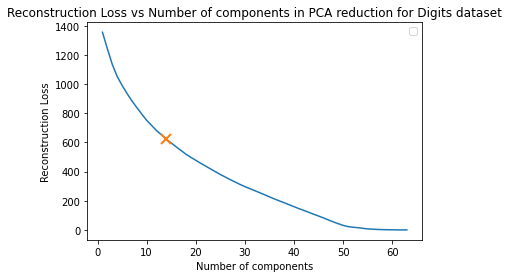

In [ ]:
''' Digits Data: Parses and splits digits dataset

      @param onehot - if true, onehot encodes labels
      @return - train test split 
'''
# loss function for the reconstruction error
def loss(original_data, reconstructed_data):
  return np.linalg.norm((original_data - reconstructed_data), None)

def digits_data(onehot=True):
  columns = []
  for i in range(0,8):
    for j in range(0,8):
      columns.append('pixel_'+str(i)+'_'+str(j))

  digits_ds = datasets.load_digits()
  digits_ds_frame = pd.concat(
      [
      pd.DataFrame(digits_ds.data, columns=columns),
      pd.DataFrame(digits_ds.target, columns=['target'])
      ],
      axis=1
  )

  losses = []
  reduced = []
  for n in range(1, 64, 1):
    pca = PCA(n_components=n)
    pca_reduced = pca.fit_transform(digits_ds_frame.iloc[:,:-1])
    pca_reconstructed = pca.inverse_transform(pca_reduced)
    losses.append(loss(digits_ds_frame.iloc[:,:-1], pca_reconstructed))
    reduced.append(pca_reduced)

  plt.plot(range(1, 64, 1), losses, mew=2, ms=10)
  plt.plot(14, losses[13], marker='x', mew=2, ms=10)
  plt.xlabel('Number of components')
  plt.ylabel('Reconstruction Loss')
  plt.title('Reconstruction Loss vs Number of components in PCA reduction for Digits dataset')
  plt.legend()
  plt.show()

  x_train, x_test, y_train, y_test = train_test_split(digits_ds_frame.iloc[:,:-1], digits_ds_frame['target'])
  x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(reduced[14], digits_ds_frame['target'])

  if onehot:
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y_train)
    y_test = lb.transform(y_test)
    y_train_red = lb.transform(y_train_red)
    y_test_red = lb.transform(y_test_red)

  return x_train, x_test, y_train, y_test, x_train_red, x_test_red, y_train_red, y_test_red

digits_x_train, digits_x_test, digits_y_train, digits_y_test, digits_x_train_red, digits_x_test_red, digits_y_train_red, digits_y_test_red = digits_data()

### Second Dataset - Scene dataset

/usr/local/lib/python3.6/dist-packages/sklearn/datasets/_openml.py:372: UserWarning: Multiple active versions of the dataset matching the name scene exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))
No handles with labels found to put in legend.


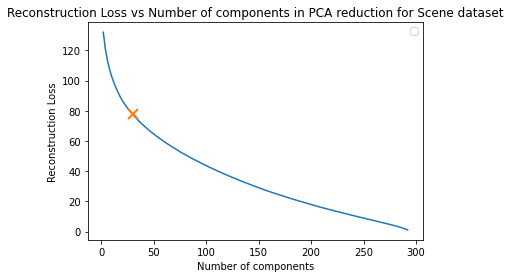

In [ ]:
# loss function for the reconstruction error
def loss(original_data, reconstructed_data):
  return np.linalg.norm((original_data - reconstructed_data), None)

scene_df = datasets.fetch_openml('scene', as_frame=True).frame

# Good'ol PCA
losses = []
reduced = []
for n in range(2, 294, 2):
  pca = PCA(n_components=n)
  pca_reduced = pca.fit_transform(scene_df.iloc[:,:-6])
  pca_reconstructed = pca.inverse_transform(pca_reduced)
  losses.append(loss(scene_df.iloc[:,:-6], pca_reconstructed))
  reduced.append(pca_reduced)

plt.plot(range(2, 294, 2), losses, mew=2, ms=10)
plt.plot(30, losses[14], marker='x', mew=2, ms=10)
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss vs Number of components in PCA reduction for Scene dataset')
plt.legend()
plt.show()

scene_x_train, scene_x_test, scene_y_train, scene_y_test = train_test_split(scene_df.iloc[:,:-6], scene_df.iloc[:, -6:])
scene_y_test = np.array(scene_y_test).astype(int)
scene_y_train = np.array(scene_y_train).astype(int)

scene_x_train_red, scene_x_test_red, scene_y_train_red, scene_y_test_red = train_test_split(reduced[14], scene_df.iloc[:, -6:])
scene_y_test_red = np.array(scene_y_test_red).astype(int)
scene_y_train_red = np.array(scene_y_train_red).astype(int)

### Second Dataset - Leaf dataset

In [ ]:
leaf_df = datasets.fetch_openml('leaf', as_frame=True).frame
leaf_x_train, leaf_x_test, leaf_y_train, leaf_y_test = train_test_split(leaf_df.iloc[:,:-1], leaf_df.iloc[:, -1:])

lb = LabelBinarizer()
leaf_y_train = lb.fit_transform(leaf_y_train)
leaf_y_test = lb.transform(leaf_y_test)

leaf_y_test = np.array(leaf_y_test).astype(int)
leaf_y_train = np.array(leaf_y_train).astype(int)

# Helper Functions

### Softmax

```
Computes the softmax vector for class c using datapoints n
@param z: x @ w
```



In [ ]:
def softmax(z):
  sm = []
  for c in z:
    c -= np.max(c)
    sm.append(np.exp(c) / np.sum(np.exp(c)))
  return np.array(sm)

### Predict Softmax

```
Returns the prediction for class c
@param x: test/validation data
@param w: weights
@param add_bias: whether or not to add bias to x
@param is_test: whether or not x is test data (or validation)
```

In [ ]:
def predict_softmax(x, w, add_bias, is_test):
  if x.ndim == 1:
    x = x[:, None]
  N = x.shape[0]
  if add_bias and is_test:
    x = np.column_stack([x,np.ones(N)])
  yh = softmax(x @ w)
  return yh

### Cross Entropy Loss

```
Returns the mean cross entropy loss/cost over all classes 
@param y_true: true labels 
@param x: data 
@param w: weights of the model
```

In [ ]:
def cost(y_true, x, w):
  cost = []
  z = x @ w
  for y, c in zip(y_true, z):
    z_bar = np.max(c)
    # scipy.logsumexp does the trick for us -- checked the docs
    cost.append(-(np.sum(y.T @ c) -  logsumexp(c)))
  
  return np.mean(cost)

### Get Accuracy

```
Returns the accuracy of the predictions
@param y_hat: predictions
@param y_true: true values
```

In [ ]:
def get_accuracy(y_hat, y_true):
  return np.sum(np.argmax(y_hat, axis=1) == np.argmax(y_true, axis=1))/y_true.shape[0]

### Cross Entropy Loss Gradients

```
Cross Entropy Loss for softmax: computes all gradients of w c,d 
@param x: train data
@param y: train targets
@param w: weights
```

In [ ]:
def cross_entropy_loss_gradients(x, y, w):
  j = []
  N = x.shape[0]
  xT = x.T

  yhat = softmax(x @ w)
  yC = (yhat-y).T  

  for x_t in xT:
    x_t = x_t[:,None]
    row = []

    for yc in yC:
      row.append(np.sum(np.dot(yc.T,x_t)))

    j.append(row)

  j = np.array(j)
  return j/N

### Get Cross-Validation Folds

```
Returns lists of cross validation splits as lists of np arrays
  * indices indicate corresponding train and validation sets 
  * training_sets[0][0] : the x_train values of the first fold 
  * training_sets[0][1] : the y_train values of the first fold
  * validation_sets[0][0] : the x_val values of the first fold
  * validation_sets[0][1] : the y_val values of the first fold
@param x_train: train data
@param y_train: train targets
```

In [ ]:
def get_cv_folds(x_train, y_train, k=5):
  C = y_train.shape[1]
  train = np.hstack((x_train, y_train))
  rand.shuffle(train)
  num_rows = math.ceil(train.shape[0]/k)

  folds = []
  for i in range(0, k):
    folds.append(train[i*num_rows:min((i+1)*num_rows, train.shape[0])]) # min is for the last fold so no out of bounds

  training_sets = []
  validation_sets = []
  for i in range(0, k):
    training = np.vstack(tuple([fold for j, fold in enumerate(folds) if j != i]))
    training_sets.append([training[:,:-C], training[:, -C:]])

    validation = folds[i]
    validation_sets.append([validation[:,:-C], validation[:,-C:]])
  
  return training_sets, validation_sets, k

# Softmax Regression

### Model

In [ ]:
class SoftmaxRegression:
  def __init__(self, add_bias=True):
    self.add_bias = add_bias

  def fit(self, x, y, optimizer):
    if x.ndim == 1:
      x = x[:, None]
    if y.ndim == 1:
      y = y[:, None]
    if self.add_bias:
      N = x.shape[0]
      x = np.column_stack([x, np.ones(N)])
    N,D = x.shape
    C = y.shape[1]
  
    self.w = np.zeros((D, C))
    self.w = optimizer.run(cross_entropy_loss_gradients, x, y, self.w)
    return self 

  def predict(self, x):
    if x.ndim == 1:
      x = x[:, None]
    N = x.shape[0]
    if self.add_bias:
      x = np.column_stack([x, np.ones(N)])
    yh = softmax(x @ self.w)
    return yh

### Optimizer

In [ ]:
class GradientDescentMomentum:
    def __init__(self,
                 x_val,
                 y_val,
                 add_bias = False,
                 learning_rate=.001, 
                 max_iters=1000, 
                 epsilon=1e-8, 
                 batch_size=32, 
                 beta=0.02,
                 termination_iterations=10
                ):
      
      self.add_bais = True,
      self.learning_rate = learning_rate
      self.max_iters = max_iters
      self.epsilon = epsilon
      self.delta_batch_weights = []
      self.batch_weights = []
      self.tracked_accuracies = []
      self.tracked_costs = []
      self.batch_size = batch_size
      self.beta = beta
      self.termination_iterations = termination_iterations

      # fixing validation sets for bias
      if x_val.ndim == 1:
        x_val = x_val[:, None]
      N = x_val.shape[0]
      if add_bias:
        x_val = np.column_stack([x_val,np.ones(N)])

      self.x_val = x_val
      self.y_val = y_val

    def create_mini_batches(self, x, y):
      mini_batches = []
      C = y.shape[1]

      # fill in mini_batches list 
      data = np.hstack((x, y))
      np.random.shuffle(data)
      n_mini_batches = data.shape[0] // self.batch_size 
      j = 0

      for j in range(n_mini_batches + 1): # from geeksforgeeks
        mini_batch = data[j * self.batch_size:(j + 1)*self.batch_size, :] 
        X_mini = mini_batch[:, :len(mini_batch[0])-C] 
        Y_mini = mini_batch[:, len(mini_batch[0])-C:]
        mini_batches.append((X_mini, Y_mini)) 
      if data.shape[0] % self.batch_size != 0: 
        mini_batch = data[j * self.batch_size:data.shape[0]] 
        X_mini = mini_batch[:, :len(mini_batch[0])-C] 
        Y_mini = mini_batch[:, len(mini_batch[0])-C:]
        mini_batches.append((X_mini, Y_mini)) 
      return mini_batches
    
    def run(self, gradient_fn, x, y, w):
      self.batch_weights.append(w)
      self.delta_batch_weights.append(w)
      self.w = w

      C = y.shape[1]
      N,D = x.shape

      batch_gradient = np.array([np.inf] * C*D)
      i = 0
      acc_termination_itr = 0
      cost_termination_itr = 0
      is_terminated = False
      mini_batches = self.create_mini_batches(x, y)

      while np.linalg.norm(batch_gradient) > self.epsilon and i < self.max_iters and (not is_terminated):      
        for mini_batch in mini_batches: 
          x_batch, y_batch = mini_batch

          batch_gradient = gradient_fn(x_batch, y_batch, self.w)

          delta_w = self.beta*self.delta_batch_weights[-1] + (1-self.beta)*batch_gradient

          self.w = self.batch_weights[-1] - self.learning_rate*delta_w

        self.delta_batch_weights.append(delta_w)
        self.batch_weights.append(self.w)


        # Keep track of train/validation accuracies at each step
        y_hat_val = softmax(self.x_val @ self.w)
        y_hat_train = softmax(x @ self.w)
        val_accuracy = get_accuracy(y_hat_val, self.y_val)
        train_accuracy = get_accuracy(y_hat_train, y)

        # If validation accuracy not increased, increase iterations
        if i > 0 and val_accuracy <= self.tracked_accuracies[-1][0]:
          acc_termination_itr += 1
          if acc_termination_itr == self.termination_iterations:
            is_terminated = True
        else:
          acc_termination_itr = 0

        self.tracked_accuracies.append([val_accuracy, train_accuracy])

        # Keep track of train/validation loss at each step
        train_cost = cost(y, x, self.w)
        val_cost = cost(self.y_val, self.x_val, self.w)

        # If change training cost not decreasing, increase cost iter
        if i > 0 and (train_cost - self.tracked_costs[-1][1]) >= -1e-05:
          cost_termination_itr += 1
          if cost_termination_itr == self.termination_iterations:
            is_terminated = True
        else: 
          cost_termination_itr = 0

        self.tracked_costs.append([val_cost, train_cost])

        i+=1

      return self.batch_weights[self.tracked_accuracies.index(max(self.tracked_accuracies))-1]


# Analysis

### Hyperparameters

We create a list of all possible combinations of hyperparameters that we want to test

In [ ]:
learning_rates = [0.001, 0.005, 0.01]
betas = np.arange(0.97, 0.99, 0.01)
batch_sizes = [2**i for i in range(7, 10)]

permutations = [[i, j, k] for i in learning_rates  
              for j in betas 
              for k in batch_sizes]

In [ ]:
def hyperparameter_tuning(ds_x_train, ds_y_train):
  train, val, k = get_cv_folds(ds_x_train, ds_y_train)

  permutations_accuracies = []
  permutations_costs = []
  models = []
  runtimes = []
  last_fold_acc =  []
  for permutation in permutations:
    start = time.time()
    alpha = permutation[0]
    beta = permutation[1]
    mb_size = permutation[2]
    models_accuracies = {}

    print('alpha:', alpha, 'beta:', beta, 'mb size:', mb_size)

    # for each fold, run the rest
    folds_accuracies = []
    folds_costs = []
    for i in range(0,k):
      x_train = train[i][0]
      y_train = train[i][1]
      x_val = val[i][0]
      y_val = val[i][1]

      print(f'************* Fold {i+1} *************')
      # We can finally fit our model
      optimizer = GradientDescentMomentum(x_val=x_val, y_val=y_val, 
                                          add_bias=True,
                                          learning_rate=alpha, 
                                          beta=beta, 
                                          batch_size=mb_size, 
                                          max_iters=300)
      model = SoftmaxRegression().fit(x_train, y_train, optimizer)
      folds_accuracies.append(max(optimizer.tracked_accuracies))
      folds_costs.append(optimizer.tracked_costs)
      models_accuracies.update({model: max(optimizer.tracked_accuracies)})
    
    end = time.time()
    runtime = end-start
    print(f'Runtime: {runtime}s')
    last_fold_acc.append(optimizer.tracked_accuracies)
    runtimes.append(runtime)
    permutations_costs.append(folds_costs)
    permutations_accuracies.append(max(folds_accuracies))
    models.append(max(models_accuracies, key=models_accuracies.get))
    print(folds_accuracies)
    print(f'Average Validation Accuracy for this combo: {np.mean(folds_accuracies)}')
    print('\n\n')
  return (permutations_accuracies, permutations_costs, runtimes, last_fold_acc, models)

In [ ]:
def plot_hyperparameter_tuning(d, string):
  best_acc_index = d[0].index(max(d[0])) 
  best_acc = d[0][best_acc_index]
  best_acc_runtime = d[2][best_acc_index]
  best_hp_combo = permutations[best_acc_index]

  worst_acc_index = d[0].index(min(d[0]))
  worst_acc = d[0][worst_acc_index]
  worst_acc_runtime = d[2][worst_acc_index]
  worst_hp_combo = permutations[worst_acc_index]

  best_run_index = d[2].index(min(d[2]))
  best_run_acc = d[0][best_run_index]
  best_run_runtime = d[2][best_run_index]
  fast_hp_combo = permutations[best_run_index]

  worst_run_index = d[2].index(max(d[2]))
  worst_run_acc = d[0][worst_run_index]
  worst_run_runtime = d[2][worst_run_index]
  slow_hp_combo = permutations[worst_run_index]

  print(f'Best model: {best_hp_combo}, Accuracy: {best_acc}, Runtime: {best_acc_runtime}')
  print(f'Worst model: {worst_hp_combo}, Accuracy: {worst_acc}, Runtime: {worst_acc_runtime}')
  print(f'Fastest model: {fast_hp_combo}, Accuracy: {best_run_acc}, Runtime: {best_run_runtime}')
  print(f'Slowest model: {slow_hp_combo}, Accuracy: {worst_run_acc}, Runtime: {worst_run_runtime}')
  print(best_acc)

  best_acc_data = []
  worst_acc_data = []
  best_run_data = []
  worst_run_data = []
  best_acc_data_train = []
  worst_acc_data_train = []
  best_run_data_train = []
  worst_run_data_train = []
  for a_tuple in d[3][best_acc_index]:
    best_acc_data.append(a_tuple[0])
    best_acc_data_train.append(a_tuple[1])

  for a_tuple in d[3][worst_acc_index]:
    worst_acc_data.append(a_tuple[0])
    worst_acc_data_train.append(a_tuple[1])

  for a_tuple in d[3][best_run_index]:
    best_run_data.append(a_tuple[0])
    best_run_data_train.append(a_tuple[1])

  for a_tuple in d[3][worst_run_index]:
    worst_run_data.append(a_tuple[0])
    worst_run_data_train.append(a_tuple[1])

  best_time_steps = [i for i in range(0,len(best_acc_data))]
  worst_time_steps = [i for i in range(0,len(worst_acc_data))]
  fastest_time_steps = [i for i in range(0,len(best_run_data))]
  slowest_time_steps = [i for i in range(0,len(worst_run_data))]


  print(len(best_acc_data))
  print(len(worst_acc_data))
  print(len(best_run_data))
  print(len(worst_run_data))
  print(f'data: {best_acc_data}')
  fig = plt.figure(figsize=(10,5))

  ax1 = fig.add_subplot(1,2,1)
  ax1.plot(worst_time_steps, worst_acc_data, mew=2, ms=10, c='r', alpha=0.8, label='Worst Validation')
  ax1.plot(worst_time_steps, worst_acc_data_train, mew=2, ms=10, c='r', alpha=0.6, linestyle='dashed', label='Worst Training')
  ax1.plot(best_time_steps, best_acc_data, mew=2, ms=10, c='b', alpha=0.8, label='Best Validation')
  ax1.plot(best_time_steps, best_acc_data_train, mew=2, ms=10, c='b', linestyle='dashed', alpha=0.6, label='Best Training')

  ax1.set_xlabel('Time Steps')
  ax1.set_ylabel('Accuracy')
  ax1.set_title(f'{string} Train/Val Accuracy vs Time Step for \none-fold of Best and Worst combos of HPs')
  ax1.legend()

  ax2 = fig.add_subplot(1,2,2)
  ax2.plot(slowest_time_steps, worst_run_data, mew=2, ms=10, c='r', alpha=0.8, label="Slowest Validation")
  ax2.plot(slowest_time_steps, worst_run_data_train, mew=2, ms=10, c='r', linestyle='dashed', alpha=0.6,label="Slowest Training")
  ax2.plot(fastest_time_steps, best_run_data, mew=2, ms=10,  c='b', alpha=0.8, label="Fastest Validation")
  ax2.plot(fastest_time_steps, best_run_data_train, mew=2, ms=10,  c='b', linestyle='dashed', alpha=0.6, label="Fastest Training")
  ax2.set_xlabel('Time Steps')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(f'{string} Train/Val Accuracy vs Time for \none-fold of Slowest and Fastest combos of HPs')
  ax2.legend()

  fig.tight_layout()
  plt.show()
  return (best_hp_combo, worst_hp_combo, fast_hp_combo, slow_hp_combo)

### Digits dataset

We start by finding the best combination of Hyperparameters. Then we plot the accuracies obtained based on several combinations of Hyperparameters, namely those giving best accuracy, worst accuracy, best runtime and worst runtime

alpha: 0.001 beta: 0.97 mb size: 128
************* Fold 1 *************
************* Fold 2 *************
************* Fold 3 *************
************* Fold 4 *************
************* Fold 5 *************
Runtime: 101.88297033309937s
[[0.8481481481481481, 0.8245125348189415], [0.1, 0.10306406685236769], [0.8481481481481481, 0.8421541318477251], [0.3296296296296296, 0.34540389972144847], [0.8127340823970037, 0.8296296296296296]]
Average Validation Accuracy for this combo: 0.5883424271193042



alpha: 0.001 beta: 0.97 mb size: 256
************* Fold 1 *************
************* Fold 2 *************
************* Fold 3 *************
************* Fold 4 *************
************* Fold 5 *************
Runtime: 90.66908121109009s
[[0.8074074074074075, 0.8282265552460538], [0.7814814814814814, 0.7753017641597029], [0.8740740740740741, 0.83008356545961], [0.8037037037037037, 0.8449396471680595], [0.08239700374531835, 0.10833333333333334]]
Average Validation Accuracy for this combo: 

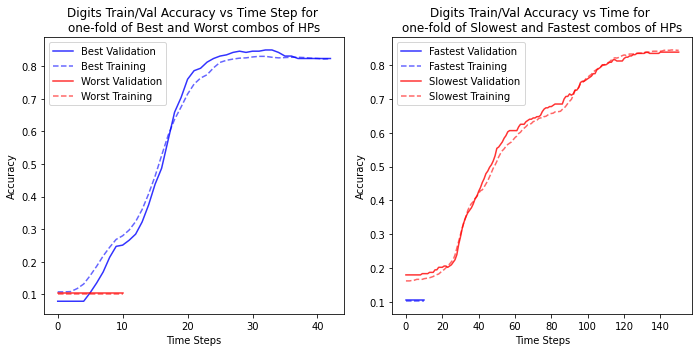

In [ ]:
digits_info = hyperparameter_tuning(digits_x_train, digits_y_train)
digits_combos = plot_hyperparameter_tuning(digits_info, 'Digits')

alpha: 0.001 beta: 0.97 mb size: 128
************* Fold 1 *************
************* Fold 2 *************
************* Fold 3 *************
************* Fold 4 *************
************* Fold 5 *************
Runtime: 8.28453803062439s
[[0.6444444444444445, 0.6778087279480037], [0.6222222222222222, 0.649025069637883], [0.7074074074074074, 0.6973073351903436], [0.6074074074074074, 0.637883008356546], [0.7677902621722846, 0.7194444444444444]]
Average Validation Accuracy for this combo: 0.6730740329230986



alpha: 0.001 beta: 0.97 mb size: 256
************* Fold 1 *************
************* Fold 2 *************
************* Fold 3 *************
************* Fold 4 *************
************* Fold 5 *************
Runtime: 8.77922511100769s
[[0.7814814814814814, 0.8180129990714949], [0.6925925925925925, 0.6852367688022284], [0.7888888888888889, 0.7845868152274837], [0.7444444444444445, 0.7771587743732591], [0.7191011235955056, 0.662962962962963]]
Average Validation Accuracy for this 

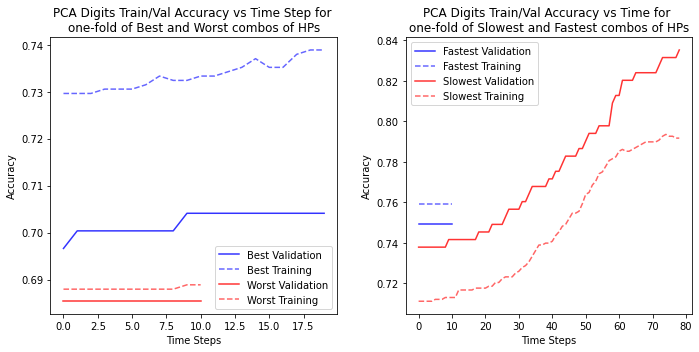

In [ ]:
digits_info_red = hyperparameter_tuning(digits_x_train_red, digits_y_train_red)
digits_combos_red = plot_hyperparameter_tuning(digits_info_red, 'PCA Digits')

**So the best combination of hyperparameters $(Learning \; Rate,\; Beta,\; Minibatch \; Size)$ is:**


In [ ]:
# print(f'Best Digits Hyperparameter Combination: {digits_combos[0]}')
print(f'Best Digits Reduced Hyperparameter Combination: {digits_combos_red[0]}')

Best Digits Reduced Hyperparameter Combination: [0.005, 0.97, 512]


**After hyperparameter tuning we get the following accuracy on the test set:**

In [ ]:
# Best digits model on test set 
best_acc_index = digits_info[0].index(max(digits_info[0])) 
best_acc = digits_info[0][best_acc_index]
best_acc_runtime = digits_info[2][best_acc_index]
best_hp_combo = permutations[best_acc_index]
best_hp_model = digits_info[4][best_acc_index]

y_hat = best_hp_model.predict(digits_x_test)
print(f'Test Accuracy for Best Hyperparameter Combo: {get_accuracy(y_hat, digits_y_test)}')
print(f'Best digits combo: {best_hp_combo}, {best_acc_runtime}s')

Test Accuracy for Best Hyperparameter Combo: 0.8666666666666667
Best digits combo: [0.01, 0.98, 512], 61.81846857070923s


In [ ]:
# Best digits reduced model on test set 
best_acc_index = digits_info_red[0].index(max(digits_info_red[0])) 
best_acc = digits_info_red[0][best_acc_index]
best_acc_runtime = digits_info_red[2][best_acc_index]
best_hp_combo = permutations[best_acc_index]
best_hp_model = digits_info_red[4][best_acc_index]

y_hat = best_hp_model.predict(digits_x_test_red)
print(f'Test Accuracy for Best Hyperparameter Combo: {get_accuracy(y_hat, digits_y_test_red)}')
print(f'Best digits reduced combo: {best_hp_combo}, {best_acc_runtime}s')

Test Accuracy for Best Hyperparameter Combo: 0.8777777777777778
Best digits reduced combo: [0.01, 0.98, 256], 36.70925951004028s


In [ ]:
optimizer = GradientDescentMomentum(x_val=digits_x_test, y_val=digits_y_test, 
                                        add_bias=True,
                                        learning_rate=digits_combos[0][0], 
                                        beta=digits_combos[0][1], 
                                        batch_size=digits_combos[0][2], 
                                        max_iters=1000)
model = SoftmaxRegression().fit(digits_x_train, digits_y_train, optimizer)
y_hat = model.predict(digits_x_test)
print(f'Accuracy for Best Hyperparameter combo: {get_accuracy(y_hat, digits_y_test)}')

### Scene dataset

Hyper-parameter tuning for the second dataset

alpha: 0.001 beta: 0.97 mb size: 128
************* Fold 1 *************
************* Fold 2 *************
************* Fold 3 *************
************* Fold 4 *************
************* Fold 5 *************
Runtime: 22.84799814224243s
[[0.20498614958448755, 0.20429362880886426], [0.12188365650969529, 0.1793628808864266], [0.18282548476454294, 0.17520775623268697], [0.2742382271468144, 0.21745152354570638], [0.18559556786703602, 0.1745152354570637]]
Average Validation Accuracy for this combo: 0.19203601108033239



alpha: 0.001 beta: 0.97 mb size: 256
************* Fold 1 *************
************* Fold 2 *************
************* Fold 3 *************
************* Fold 4 *************
************* Fold 5 *************
Runtime: 20.997023820877075s
[[0.16066481994459833, 0.17382271468144045], [0.16620498614958448, 0.17659279778393353], [0.18282548476454294, 0.17590027700831026], [0.18282548476454294, 0.2077562326869806], [0.18559556786703602, 0.19390581717451524]]
Average Valida

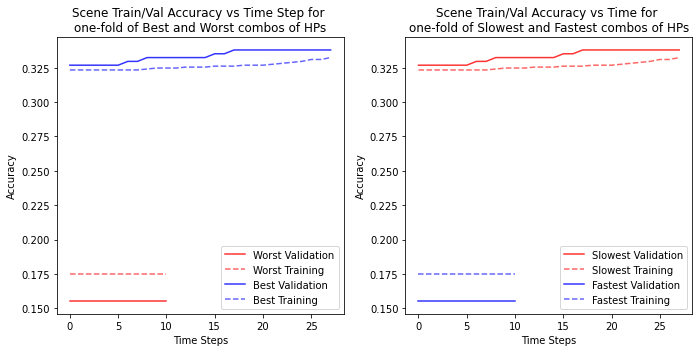

In [ ]:
scene_info = hyperparameter_tuning(scene_x_train, scene_y_train)

alpha: 0.001 beta: 0.97 mb size: 128
************* Fold 1 *************
************* Fold 2 *************
************* Fold 3 *************
************* Fold 4 *************
************* Fold 5 *************
Runtime: 12.373833894729614s
[[0.4709141274238227, 0.49238227146814406], [0.4376731301939058, 0.4037396121883656], [0.48753462603878117, 0.4342105263157895], [0.40166204986149584, 0.40304709141274236], [0.4404432132963989, 0.46537396121883656]]
Average Validation Accuracy for this combo: 0.4436980609418283



alpha: 0.001 beta: 0.97 mb size: 256
************* Fold 1 *************
************* Fold 2 *************
************* Fold 3 *************
************* Fold 4 *************
************* Fold 5 *************
Runtime: 11.991899251937866s
[[0.6204986149584487, 0.6606648199445984], [0.590027700831025, 0.574792243767313], [0.5955678670360111, 0.600415512465374], [0.5706371191135734, 0.5450138504155124], [0.6648199445983379, 0.6793628808864266]]
Average Validation Accuracy 

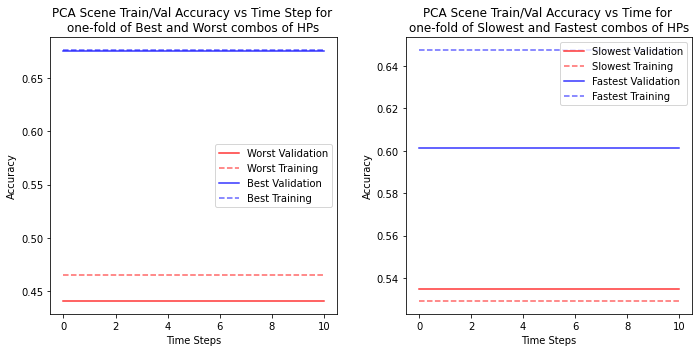

In [ ]:
scene_info_red = hyperparameter_tuning(scene_x_train_red, scene_y_train_red)
scene_combos_red = plot_hyperparameter_tuning(scene_info_red, 'PCA Scene')

**So the best combination of hyperparameters $(Learning \; Rate,\; Beta,\; Minibatch \; Size)$ is:**


In [ ]:
print(f'Best Scene Hyperparameter Combination: {scene_combos[0]}')
print(f'Best Scene Reduced Hyperparameter Combination: {scene_combos_red[0]}')

Best Hyperparameter Combination: [0.01, 0.97, 256]


**After hyperparameter tuning we get the following accuracy on the test set:**

In [ ]:
# Best scene model on test set 
best_acc_index = scene_info[0].index(max(scene_info[0])) 
best_acc = scene_info[0][best_acc_index]
best_acc_runtime = scene_info[2][best_acc_index]
best_hp_combo = permutations[best_acc_index]
best_hp_model = scene_info[4][best_acc_index]

y_hat = best_hp_model.predict(scene_x_test)
print(f'Test Accuracy for Best Hyperparameter Combo: {get_accuracy(y_hat, scene_y_test)}')
print(f'Best scene combo: {best_hp_combo}, {best_acc_runtime}s')

Test Accuracy for Best Hyperparameter Combo: 0.6029900332225914
Best scene combo: [0.01, 0.97, 512], 113.30554533004761s


In [ ]:
# Best scene reducded model on test set 
best_acc_index = scene_info_red[0].index(max(scene_info_red[0])) 
best_acc = scene_info_red[0][best_acc_index]
best_acc_runtime = scene_info_red[2][best_acc_index]
best_hp_combo = permutations[best_acc_index]
best_hp_model = scene_info_red[4][best_acc_index]

y_hat = best_hp_model.predict(scene_x_test_red)
print(f'Test Accuracy for Best Hyperparameter Combo: {get_accuracy(y_hat, scene_y_test_red)}')
print(f'Best scene reduced combo: {best_hp_combo}, {best_acc_runtime}s')

Test Accuracy for Best Hyperparameter Combo: 0.6777408637873754
Best scene reduced combo: [0.01, 0.97, 256], 12.056355476379395s


### Leaf dataset

Hyperparameter tuning for the third dataset (hella fast cuz very little data)

alpha: 0.001 beta: 0.97 mb size: 128
************* Fold 1 *************
************* Fold 2 *************
************* Fold 3 *************
************* Fold 4 *************
************* Fold 5 *************
Runtime: 1.9342284202575684s
[[0.0784313725490196, 0.058823529411764705], [0.058823529411764705, 0.08823529411764706], [0.0784313725490196, 0.06862745098039216], [0.058823529411764705, 0.09313725490196079], [0.058823529411764705, 0.08823529411764706]]
Average Validation Accuracy for this combo: 0.07303921568627451



alpha: 0.001 beta: 0.97 mb size: 256
************* Fold 1 *************
************* Fold 2 *************
************* Fold 3 *************
************* Fold 4 *************
************* Fold 5 *************
Runtime: 1.8514447212219238s
[[0.0392156862745098, 0.10294117647058823], [0.09803921568627451, 0.0784313725490196], [0.0784313725490196, 0.09313725490196079], [0.09803921568627451, 0.0784313725490196], [0.058823529411764705, 0.09313725490196079]]
Average Va

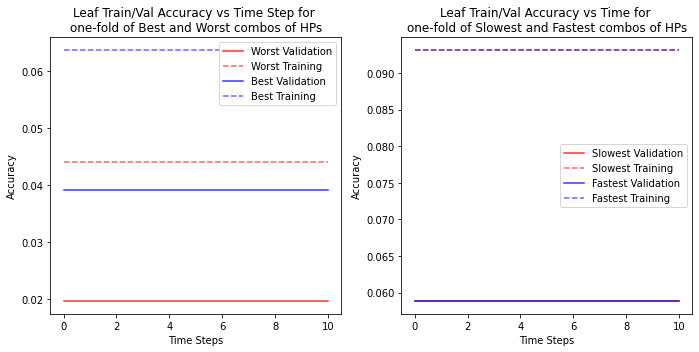

In [ ]:
leaf_info = hyperparameter_tuning(leaf_x_train, leaf_y_train)
leaf_combos = plot_hyperparameter_tuning(leaf_info, 'Leaf')

**So the best combination of hyperparameters $(Learning \; Rate,\; Beta,\; Minibatch \; Size)$ is:**


In [ ]:
print(f'Best Hyperparameter Combination: {leaf_combos[0]}')

Best Hyperparameter Combination: [0.001, 0.98, 128]


**After hyperparameter tuning we get the following accuracy on the test set:**

In [ ]:
# Best scene model on test set 
best_acc_index = leaf_info[0].index(max(leaf_info[0])) 
best_acc = leaf_info[0][best_acc_index]
best_acc_runtime = leaf_info[2][best_acc_index]
best_hp_combo = permutations[best_acc_index]
best_hp_model = leaf_info[4][best_acc_index]

y_hat = best_hp_model.predict(leaf_x_test)
print(f'Test Accuracy for Best Hyperparameter Combo: {get_accuracy(y_hat, leaf_y_test)}')
print(f'Best leaf combo: {best_hp_combo}, {best_acc_runtime}s')

Test Accuracy for Best Hyperparameter Combo: 0.08235294117647059
Best leaf combo: [0.001, 0.98, 128], 1.8270342350006104s


### Second Classifier: KNN

In [ ]:
num_neighbors = [i for i in range(1, 8)]#[i for i in range(1, 11)]
metrics = [1, 2, 5] # [manhattan, euclidean, minkowski]

knn_perms = [[i, j ] for i in num_neighbors 
                for j in metrics]

In [ ]:
def knn_hyperparameter_tuning(ds_x_train, ds_y_train, permutations):
  train, val, k = get_cv_folds(ds_x_train, ds_y_train)
  num_neighbors = [i for i in range(1, 11)]
              
  euclidean_acc = []
  manhattan_acc = []
  minkowski_acc = []
  for k, p in permutations:
    KNN = KNeighborsClassifier(n_neighbors= k, weights='distance', p=p)
    train_accuracies = []
    val_accuracies = []
    start = time.time()
    for i in range(0, 5):
      x_train = train[i][0]
      y_train = train[i][1]
      x_val = val[i][0]
      y_val = val[i][1]

      KNN.fit(x_train, y_train)
      train_pred = KNN.predict(x_train)
      val_pred = KNN.predict(x_val)
      train_acc = get_accuracy(train_pred, y_train)
      val_acc = get_accuracy(val_pred, y_val)

      train_accuracies.append(train_acc)
      val_accuracies.append(val_acc)

    end = time.time()
    runtime = end-start
 
    
    if p==2: # equivalent to euclidean
      euclidean_acc.append(np.mean(val_accuracies))
    elif p==1: # equivalent to manhattan
      manhattan_acc.append(np.mean(val_accuracies))
    else: # minkowski with p > 2 = 5
      minkowski_acc.append(np.mean(val_accuracies)) 
    print(f'K = {k}; Metric = {p}')
    print(f'Train accuracy = {np.mean(train_accuracies)}')
    print(f'Validation accuracy = {np.mean(val_accuracies)}')
    print(f'Runtime = {runtime}\n\n')
  
  return (euclidean_acc, manhattan_acc, minkowski_acc)


In [ ]:
knn_digits = knn_hyperparameter_tuning(digits_x_train, digits_y_train, knn_perms)

K = 1; Metric = 1
Train accuracy = 1.0
Validation accuracy = 0.9762630045776113
Runtime = 0.3433568477630615


K = 1; Metric = 2
Train accuracy = 1.0
Validation accuracy = 0.9829546400332918
Runtime = 0.3276684284210205


K = 1; Metric = 5
Train accuracy = 1.0
Validation accuracy = 0.9829546400332918
Runtime = 4.159704685211182


K = 2; Metric = 1
Train accuracy = 1.0
Validation accuracy = 0.9755222638368707
Runtime = 1.0078442096710205


K = 2; Metric = 2
Train accuracy = 1.0
Validation accuracy = 0.9829546400332918
Runtime = 0.934614896774292


K = 2; Metric = 5
Train accuracy = 1.0
Validation accuracy = 0.9829546400332918
Runtime = 14.829830169677734


K = 3; Metric = 1
Train accuracy = 1.0
Validation accuracy = 0.9710778193924261
Runtime = 1.0182745456695557


K = 3; Metric = 2
Train accuracy = 1.0
Validation accuracy = 0.9829463171036205
Runtime = 0.9670052528381348


K = 3; Metric = 5
Train accuracy = 1.0
Validation accuracy = 0.9770037453183521
Runtime = 16.451690435409546


K =

In [ ]:
knn_scene = knn_hyperparameter_tuning(scene_x_train, scene_y_train, knn_perms)

K = 1; Metric = 1
Train accuracy = 0.9995844875346259
Validation accuracy = 0.7185595567867036
Runtime = 2.211763381958008


K = 1; Metric = 2
Train accuracy = 0.9995844875346259
Validation accuracy = 0.6847645429362881
Runtime = 2.2396419048309326


K = 1; Metric = 5
Train accuracy = 0.9995844875346259
Validation accuracy = 0.5922437673130194
Runtime = 64.29761290550232


K = 2; Metric = 1
Train accuracy = 0.9995844875346259
Validation accuracy = 0.7185595567867036
Runtime = 8.213943481445312


K = 2; Metric = 2
Train accuracy = 0.9995844875346259
Validation accuracy = 0.6847645429362881
Runtime = 8.201988935470581


K = 2; Metric = 5
Train accuracy = 0.9995844875346259
Validation accuracy = 0.5922437673130194
Runtime = 284.68529868125916


K = 3; Metric = 1
Train accuracy = 0.9995844875346259
Validation accuracy = 0.7313019390581716
Runtime = 8.210572004318237


K = 3; Metric = 2
Train accuracy = 0.9995844875346259
Validation accuracy = 0.7146814404432134
Runtime = 8.289364337921143


In [ ]:
knn_leaf = knn_hyperparameter_tuning(leaf_x_train, leaf_y_train, knn_perms)

K = 1; Metric = 1
Train accuracy = 1.0
Validation accuracy = 0.1411764705882353
Runtime = 0.05532956123352051


K = 1; Metric = 2
Train accuracy = 1.0
Validation accuracy = 0.09803921568627452
Runtime = 0.041626691818237305


K = 1; Metric = 5
Train accuracy = 1.0
Validation accuracy = 0.09803921568627452
Runtime = 0.1292576789855957


K = 2; Metric = 1
Train accuracy = 1.0
Validation accuracy = 0.1411764705882353
Runtime = 0.05236983299255371


K = 2; Metric = 2
Train accuracy = 1.0
Validation accuracy = 0.09803921568627452
Runtime = 0.044289350509643555


K = 2; Metric = 5
Train accuracy = 1.0
Validation accuracy = 0.09803921568627452
Runtime = 0.1705167293548584


K = 3; Metric = 1
Train accuracy = 1.0
Validation accuracy = 0.14901960784313725
Runtime = 0.052124977111816406


K = 3; Metric = 2
Train accuracy = 1.0
Validation accuracy = 0.10980392156862746
Runtime = 0.046018123626708984


K = 3; Metric = 5
Train accuracy = 1.0
Validation accuracy = 0.09803921568627452
Runtime = 0.196

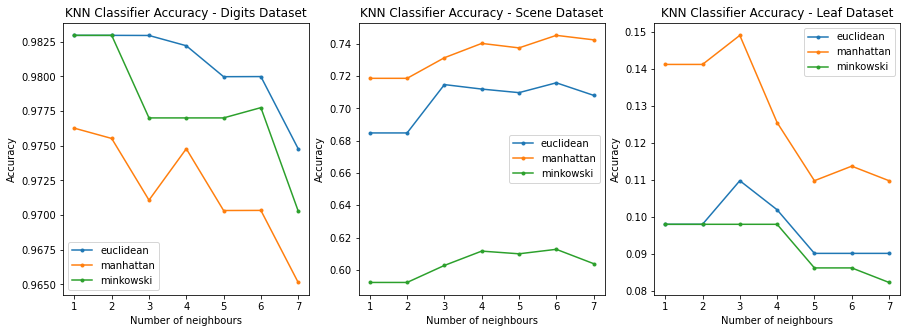

In [ ]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3 ,1)
ax1.plot(num_neighbors, knn_digits[0], marker='.', label='euclidean')
ax1.plot(num_neighbors, knn_digits[1], marker='.',  label='manhattan')
ax1.plot(num_neighbors, knn_digits[2], marker='.', label='minkowski')
ax1.set_xlabel('Number of neighbours')
ax1.set_ylabel('Accuracy')
ax1.set_title('KNN Classifier Accuracy - Digits Dataset')
ax1.legend()

ax2 = fig.add_subplot(1,3,2)
ax2.plot(num_neighbors, knn_scene[0], marker='.', label='euclidean')
ax2.plot(num_neighbors, knn_scene[1], marker='.',  label='manhattan')
ax2.plot(num_neighbors, knn_scene[2], marker='.', label='minkowski')
ax2.set_xlabel('Number of neighbours')
ax2.set_ylabel('Accuracy')
ax2.set_title('KNN Classifier Accuracy - Scene Dataset')
ax2.legend()

ax3 = fig.add_subplot(1,3,3)
ax3.plot(num_neighbors, knn_leaf[0], marker='.', label='euclidean')
ax3.plot(num_neighbors, knn_leaf[1], marker='.',  label='manhattan')
ax3.plot(num_neighbors, knn_leaf[2], marker='.', label='minkowski')
ax3.set_xlabel('Number of neighbours')
ax3.set_ylabel('Accuracy')
ax3.set_title('KNN Classifier Accuracy - Leaf Dataset')
ax3.legend()
plt.show()

Based on Graphs, we have different ideal combinations of HPs

In [ ]:
KNN = KNeighborsClassifier(n_neighbors= 4, weights='distance', p=2)
KNN.fit(digits_x_train, digits_y_train)
y_hat = KNN.predict(digits_x_test)
print(f'Digits KNN Accuracy: {get_accuracy(y_hat, digits_y_test)}')

KNN = KNeighborsClassifier(n_neighbors= 4, weights='distance', p=1)
KNN.fit(scene_x_train, scene_y_train)
y_hat = KNN.predict(scene_x_test)
print(f'Scene KNN Accuracy: {get_accuracy(y_hat, scene_y_test)}')

KNN = KNeighborsClassifier(n_neighbors= 2, weights='distance', p=1)
KNN.fit(leaf_x_train, leaf_y_train)
y_hat = KNN.predict(leaf_x_test)
print(f'Leaf KNN Accuracy: {get_accuracy(y_hat, leaf_y_test)}')


Digits KNN Accuracy: 0.9955555555555555
Scene KNN Accuracy: 0.7425249169435216
Leaf KNN Accuracy: 0.18823529411764706


**CNN MODEL**

In [ ]:
(cnn_train_x, cnn_train_y), (cnn_val_x, cnn_val_y) = keras.datasets.mnist.load_data() # load mnist

cnn_train_x = cnn_train_x.reshape((cnn_train_x.shape[0], 28, 28, 1)) #reshape
cnn_val_x = cnn_val_x.reshape((cnn_val_x.shape[0], 28, 28, 1))
cnn_train_y = to_categorical(cnn_train_y) #one-hot
cnn_val_y = to_categorical(cnn_val_y)
cnn_train_x = cnn_train_x.astype('float32') # as float
cnn_val_x = cnn_val_x.astype('float32')
cnn_train_x = cnn_train_x/255 # normalize
cnn_val_x = cnn_val_x/255

def conv_model():
  model = Sequential()
  model.add(layers.Conv2D(32, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  return model




In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(5, shuffle=True, random_state = 1)

accuracies = []
count = 0
for train, test in kfold.split(cnn_train_x):
  print(f'******************************************** Fold {count} ********************************************')
  train_x, train_y, test_x, test_y = cnn_train_x[train], cnn_train_y[train], cnn_train_x[test], cnn_train_y[test]
  model = conv_model()
  model.compile(optimizer="Adam", loss=keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])
  model.fit(train_x, train_y, epochs=10, batch_size=32, validation_data=(test_x, test_y))
  _, acc = model.evaluate(test_x, test_y, verbose=0)
  print(model.evaluate(cnn_val_x, cnn_val_y))
  accuracies.append(acc)
  count = count+1

print(accuracies)
print(np.mean(accuracies))

******************************************** Fold 0 ********************************************
Epoch 1/10
1500/1500 [==============================] - 32s 21ms/step - loss: 0.1767 - accuracy: 0.9473 - val_loss: 0.0758 - val_accuracy: 0.9777
Epoch 2/10
1500/1500 [==============================] - 32s 21ms/step - loss: 0.0591 - accuracy: 0.9821 - val_loss: 0.0633 - val_accuracy: 0.9808
Epoch 3/10
1500/1500 [==============================] - 31s 21ms/step - loss: 0.0365 - accuracy: 0.9889 - val_loss: 0.0713 - val_accuracy: 0.9786
Epoch 4/10
1500/1500 [==============================] - 32s 21ms/step - loss: 0.0257 - accuracy: 0.9918 - val_loss: 0.0555 - val_accuracy: 0.9843
Epoch 5/10
1500/1500 [==============================] - 31s 21ms/step - loss: 0.0180 - accuracy: 0.9941 - val_loss: 0.0614 - val_accuracy: 0.9834
Epoch 6/10
1500/1500 [==============================] - 31s 21ms/step - loss: 0.0126 - accuracy: 0.9960 - val_loss: 0.0625 - val_accuracy: 0.9850
Epoch 7/10
1500/1500 [=====

Average 5-fold accuracy is $98.46$